In [2]:
# imports libraries
from collections import defaultdict
import sys
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
from sklearn import preprocessing
#from sklearn.metrics import roc_curve, auc
from numpy.random import seed
#from scipy.special import cbrt
#import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
#from scipy.stats import rankdata
import cPickle
%matplotlib inline

# reproduce results
seed(584)

In [3]:
train = pd.read_csv('data/train_FBFog7d.csv')
test = pd.read_csv('data/Test_L4P23N3.csv')
train.shape, test.shape

((10357, 18), (3387, 17))

In [4]:
#import the additional variable provided
alcohol = pd.read_csv('data/NewVariable_Alcohol.csv')
alcohol.shape

(13744, 2)

In [5]:
train = train.merge(alcohol, on='ID')
test = test.merge(alcohol, on='ID')
train.shape, test.shape

((10357, 19), (3387, 18))

In [6]:
categorical_vars = ['Var1', 'WorkStatus', 'Divorce', 'Widowed', 'Residence_Region', 'income', 'Engagement_Religion', 
                    u'babies', u'preteen', u'teens', 'Var2', 'Gender', 'Unemployed10', 'Alcohol_Consumption']

In [7]:
#encoding some of the categorical vars to capture information in their ordering
number = preprocessing.LabelEncoder()
for var in ['WorkStatus', 'Residence_Region', 'income', 'Engagement_Religion', 'Alcohol_Consumption']:
    train[var+'_encoded'] = number.fit_transform(train[var].astype('str'))
    test[var+'_encoded'] = number.fit_transform(test[var].astype('str'))

In [8]:
numeric_vars = [u'Education', u'TVhours', 'Score']

In [9]:
#merging rare levels
train.ix[train['babies'] >= 3, 'babies'] = 3
test.ix[test['babies'] >= 3, 'babies'] = 3

train.ix[train['preteen'] >= 4, 'preteen'] = 4
test.ix[test['babies'] >= 4, 'preteen'] = 4

train.ix[train['teens'] >= 3, 'teens'] = 3
test.ix[test['teens'] >= 3, 'teens'] = 3

In [10]:
#removing outliers as per standard deviation
outlier_cutoff = 7
for feature in numeric_vars:
    train[feature + '_std'] = np.abs( (train[feature] - train[feature].mean()) / train[feature].std() )
    if len( train.ix[ train[ feature + '_std' ] > outlier_cutoff, feature ] ) > 0:
        print('removing outliers in ', feature, ':\n', train.loc[ train[ feature + '_std' ] > outlier_cutoff, feature ])
        train.ix[ train[feature + '_std'] > outlier_cutoff, feature ] = np.nan
    train.drop( [feature + '_std'], axis=1, inplace=True)

('removing outliers in ', u'TVhours', ':\n', 668     24
1884    22
1949    22
2261    24
3382    20
4033    20
4207    20
4734    20
5521    24
5556    20
6046    24
6409    21
7251    24
7732    20
Name: TVhours, dtype: float64)


In [11]:
#removing outliers in test set
outlier_cutoff = 7
for feature in numeric_vars:
    test[feature + '_std'] = np.abs( (test[feature] - test[feature].mean()) / test[feature].std() )
    if len( test.ix[ test[ feature + '_std' ] > outlier_cutoff, feature ] ) > 0:
        print('removing outliers in ', feature, ':\n', test.loc[ test[ feature + '_std' ] > outlier_cutoff, feature ])
        test.ix[ test[feature + '_std'] > outlier_cutoff, feature ] = np.nan
    test.drop( [feature + '_std'], axis=1, inplace=True)

('removing outliers in ', u'TVhours', ':\n', 1484    21
1963    20
2019    20
2762    20
Name: TVhours, dtype: float64)


In [12]:
train['Happy'].value_counts()

Pretty Happy    5916
Very Happy      3146
Not Happy       1295
dtype: int64

In [13]:
train= train.fillna(-999)
test = test.fillna(-999)

In [14]:
data = train.copy()

label = data['Happy'].map({'Very Happy': 2, 'Pretty Happy': 1, 'Not Happy': 0})

dropCols = ['ID', 'Happy']
data.drop(dropCols, axis=1, inplace = True)

y = label
X = pd.get_dummies(data)

In [15]:
holdout_fold = StratifiedShuffleSplit(y, n_iter=1, test_size=0.25, random_state=0)
holdout_fold

StratifiedShuffleSplit(labels=[1 1 0 ..., 1 0 0], n_iter=1, test_size=0.25, random_state=0)

In [16]:
for train_index, holdout_index in holdout_fold:
    X_train, X_test = X.ix[train_index], X.ix[holdout_index]
    y_train, y_test = y[train_index], y[holdout_index]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7767, 78), (2590, 78), (7767,), (2590,))

In [17]:
#assigning higher weights to 'Not Happy' as the evaluation metric penalises higher for not classifying them correctly. 
weights = [2 if data == 0 else 0.5 if data == 1 else 0.5 for data in y_train] 

In [ ]:
#finding the ideal learning rate and num_rounds
params = {}
params["objective"] = "multi:softprob"
params["max_depth"] = 5
params["eta"] = 0.01 #higher is more conservative [0,1], if reduced then increase num_rounds
#params["eval_metric "] = 'merror'
params["seed"] = 584
params["silent"] = 1
params["nthread"] = 4
params["num_class"] = 3
plst = list(params.items())
num_rounds = 10000

xgtrain = xgb.DMatrix(X_train, label=y_train, weight = weights, missing = -999) #weight= trainX_mobN_weight
xgb.cv(params, xgtrain, num_rounds, nfold=4) #, metrics={'merror'}

xgb.cv gives the following output    

[298]	cv-test-merror:0.323916+0.010736	cv-train-merror:0.310636+0.001718    
[299]	cv-test-merror:0.323916+0.010736	cv-train-merror:0.310667+0.001610    
[300]	cv-test-merror:0.324011+0.010598	cv-train-merror:0.310481+0.001638    
[301]	cv-test-merror:0.324011+0.010598	cv-train-merror:0.310419+0.001594    
[302]	cv-test-merror:0.324105+0.010714	cv-train-merror:0.310075+0.001661    

As one can see from above the overfitting starts at around tree number 300.

In [19]:
#tuning the other parameters
params = {}
params["objective"] = "multi:softprob"
#To avoid overfitting: The first way is to directly control model complexity
params["min_child_weight"] = 6 #The larger, the more conservative the algorithm will be.
params["max_depth"] = 5
#params["gamma"] = 10 #The larger, the more conservative the algorithm will be.
params["eta"] = 0.01 #higher is more conservative [0,1], if reduced then increase num_rounds
#The second way is to add randomness to make training robust to noise
params["subsample"] = 0.7
params["colsample_bytree"] = 0.7

#Handle Imbalanced Dataset
#If you care only about the ranking order (AUC) of your prediction
#params["scale_pos_weight"] = 1 #ratio of labels in target variable
#params["eval_metric "] = 'mlogloss'
#If you care about predicting the right probability
#params["max_delta_step"]= 10 #should be high for skewed data

params["seed"] = 584
params["silent"] = 1
params["nthread"] = 4
params["num_class"] = 3
plst = list(params.items())
num_rounds = 300

In [20]:
#training the model with the above parameters 
xgtrain = xgb.DMatrix(X_train, label=y_train, weight = weights, missing = -999)
xgtest = xgb.DMatrix(X_test)
model = xgb.train(plst, xgtrain, num_rounds)

In [21]:
pred_ytest = model.predict(xgtest)

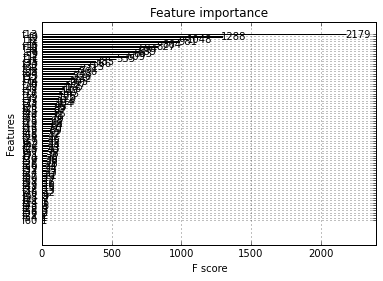

In [22]:
xgb.plot_importance(model)

In [23]:
#predicting probabilities
X_test['prediction'] = np.argmax(pred_ytest.reshape( y_test.shape[0], 3 ), axis=1)
X_test['prediction'].value_counts()

1    2139
0     307
2     144
dtype: int64

In [24]:
confusion_matrix(X_test['prediction'],y_test)

array([[ 237,   42,   28],
       [  84, 1388,  667],
       [   3,   49,   92]])

In [25]:
#calculating the evaluation metric
score = 0
points = []
for (predicted, true) in zip(X_test['prediction'].astype(str).map({'2':15, '1': 10, '0': 5}), 
                             y_test.astype(str).map({'2':15, '1': 10, '0': 5})):
    points.append(true - predicted)
X_test['Point'] = points
X_test['Score'] = X_test['Point'].astype(str).map({'0':50, '5':10 ,'10':5, '-5':-5, '-10':-10}) 
X_test['Score'].sum()/float((len(y_test)*50))

0.7133976833976834

Saving the predictions for ensembling

In [26]:
pred_class0 = [var[0] for var in pred_ytest.reshape( y_test.shape[0], 3 )]
pred_class1 = [var[1] for var in pred_ytest.reshape( y_test.shape[0], 3 )]
pred_class2 = [var[2] for var in pred_ytest.reshape( y_test.shape[0], 3 )]

In [27]:
hold_sub = pd.DataFrame({'class0':pred_class0, 'class1':pred_class1, 'class2':pred_class2, 'y_test': y_test})
hold_sub.to_csv('data/xgb_hold_sub.csv')

Making predictions on the test set

In [28]:
#For test
test2 = test.copy()
testdropcols = list(set(dropCols)-set(['Happy']))
test2 = test2.drop(testdropcols, axis=1)

for var in test2.columns:
    new = list(set(test2[var]) - set(train[var]))
    test2.ix[test2[var].isin(new), var] = np.nan

final_test = pd.get_dummies(test2)
missingCols = list(set(X.columns)-set(final_test.columns))
for col in missingCols:
    final_test[col] = 0
final_test = final_test[X.columns]
assert X.columns.equals(final_test.columns)
final_test = final_test.fillna(-999)

In [29]:
weight_test = [2 if data == 0 else 0.5 if data == 1 else 0.5 for data in y]

In [30]:
xgtrain = xgb.DMatrix(X, label=y, weight = weight_test, missing = -999)
xgtest = xgb.DMatrix(final_test)
model_full = xgb.train(plst, xgtrain, num_rounds)
pred_finaltest = model_full.predict(xgtest)

Saving final test predictions for ensembling

In [31]:
final_class0 = [var[0] for var in pred_finaltest.reshape( final_test.shape[0], 3 )]
final_class1 = [var[1] for var in pred_finaltest.reshape( final_test.shape[0], 3 )]
final_class2 = [var[2] for var in pred_finaltest.reshape( final_test.shape[0], 3 )]

In [32]:
sub = pd.DataFrame({'ID': test['ID'], 'class0':final_class0, 'class1':final_class1, 'class2':final_class2})
sub.to_csv('data/xgb_sub.csv')